# Normative modelling as a site effect correction tool

This tutorial will walk you through the application of normative modelling as a site effect correction tool.

You will learn:
- How to fit a normative model to data from different sites.
- Choices that can be made about a normative model in a site effect context.
- How to transfer data from one site into another.
- How to make predictions for unseen sites and the rationale behind it.

# Quick recap: normative modelling using the pcntoolkit
A normative model requires three input variables:
- covariates (the X axis, ususally age)
- response variables (usually one or several brain feature measurements)
- a batch effect file. Batch effects can be anything that interferes with the covrariate (sex, site)

While the Bayesian Linear Regression (BLR) model requires input of the batch effects via a design matrix, the implementation of the Hierarchical Bayesian Regression (HBR) model only requires a text file (vector) - the design matrix is created internally.

In [1]:
# Install the toolkit
!pip install pcntoolkit

  Obtaining dependency information for argparse from https://files.pythonhosted.org/packages/f2/94/3af39d34be01a24a6e65433d19e107099374224905f1e0cc6bbe1fd22a2f/argparse-1.4.0-py2.py3-none-any.whl.metadata
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [2]:
# Import relevant libraries
import os
import pandas as pd
import pcntoolkit as ptk
import numpy as np
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
import pdb

In [4]:
# a simple function to quickly load pickle files
def ldpkl(filename: str):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [5]:
# Quick check wehere you are in your directory.
!pwd

/Users/johbay/Dropbox/OHBM2024/educational-course


In [6]:
# create working dir
root_dir = os.getcwd()

In [7]:
print(root_dir)

/Users/johbay/Dropbox/OHBM2024/educational-course


In [8]:
processing_folder = "Site_effect_tutorial/"

In [9]:
if not os.path.isdir(processing_folder):
    os.makedirs(processing_folder)

In [10]:
os.chdir(processing_folder)
processing_dir = os.getcwd()
print(f"The processing directory is: {processing_dir}")

The processing directory is: /Users/johbay/Dropbox/OHBM2024/educational-course/Site_effect_tutorial


# Step 1: Data pre-processing

### 1.1 Load the data

For this tutorial, we use publicly availabe data that has been pooled from various data sets. The data have alrrady been conveniently split into training and test set.

In [11]:
# Load the data
!wget -nc https://raw.githubusercontent.com/saigerutherford/CPC_ML_tutorial/master/data/fcon1000_tr.csv
!wget -nc https://raw.githubusercontent.com/saigerutherford/CPC_ML_tutorial/master/data/fcon1000_te.csv

File ‘fcon1000_tr.csv’ already there; not retrieving.

File ‘fcon1000_te.csv’ already there; not retrieving.



In [12]:
# Load the test data into the notebook
test_data = os.path.join(processing_dir, 'fcon1000_te.csv')
df_te = pd.read_csv(test_data, index_col=0)

# extract a list of unique site ids from the test set
site_ids_te =  sorted(set(df_te['site'].to_list()))

In [13]:
# Load the training data into the notebook
train_data = os.path.join(processing_dir, 'fcon1000_tr.csv')

df_tr = pd.read_csv(train_data, index_col=0)

# extract a list of unique site ids from the test set
site_ids_ad =  sorted(set(df_tr['site'].to_list()))

if not all(elem in site_ids_ad for elem in site_ids_te):
    print('Warning: some of the testing sites are not in the adaptation data')

### 1.2 Visual inspection of the data

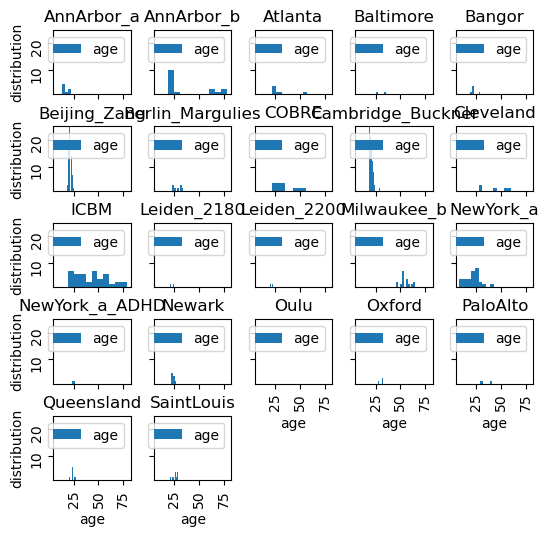

In [14]:
# Make a quick and dirty plot of the age distibution per site.
axes = df_tr.hist(['age'], by='site', layout=(5,5),
                  legend=True, yrot=90,sharex=True,sharey=True, 
                  figsize=(6,6))

for ax in axes.flatten():
    ax.set_xlabel('age')
    ax.set_ylabel('distribution')
    ax.set_ylim(bottom=1,top=25)

We see that we have 22 sites (ids: 0-21) in the data set. 
Additionally, let's now print the number of subjects per site for the training and the test set.

In [15]:
sites = df_tr['site'].unique()

print('sample size check')
for i,s in enumerate(sites):
    idx = df_tr['site'] == s
    idxte = df_te['site'] == s
    print(i,s, sum(idx), sum(idxte))

sample size check
0 AnnArbor_a 13 11
1 AnnArbor_b 20 12
2 Atlanta 11 17
3 Baltimore 12 11
4 Bangor 10 10
5 Beijing_Zang 100 98
6 Berlin_Margulies 15 11
7 Cambridge_Buckner 94 104
8 Cleveland 11 20
9 ICBM 47 38
10 Leiden_2180 6 6
11 Leiden_2200 9 10
12 Milwaukee_b 26 20
13 NewYork_a 36 47
14 NewYork_a_ADHD 7 18
15 Newark 12 7
16 Oulu 60 42
17 Oxford 10 12
18 PaloAlto 7 9
19 Queensland 12 7
20 SaintLouis 18 13
21 COBRE 20 126


In [16]:
df_tr['sitenum'] = 0
for i,s in enumerate(sites):
    idx = df_tr['site'] == s
    df_tr['sitenum'].loc[idx] = i

/var/folders/lz/nf2fw8cn0738fszl47qsj5fc0000gp/T/ipykernel_931/2802914316.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr['sitenum'].loc[idx] = i
/var/folders/lz/nf2fw8cn0738fszl47qsj5fc0000gp/T/ipykernel_931/2802914316.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr['sitenum'].loc[idx] = i
/var/folders/lz/nf2fw8cn0738fszl47qsj5fc0000gp/T/ipykernel_931/2802914316.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

In [17]:
df_te['sitenum'] = 0
for i,s in enumerate(sites):
    idx = df_te['site'] == s
    df_te['sitenum'].loc[idx] = i

/var/folders/lz/nf2fw8cn0738fszl47qsj5fc0000gp/T/ipykernel_931/2710166535.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_te['sitenum'].loc[idx] = i
/var/folders/lz/nf2fw8cn0738fszl47qsj5fc0000gp/T/ipykernel_931/2710166535.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_te['sitenum'].loc[idx] = i
/var/folders/lz/nf2fw8cn0738fszl47qsj5fc0000gp/T/ipykernel_931/2710166535.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

### 1.3 Set aside of hold-out transfer sites
For our site transfer later we want to exclude some sites from the training and test set for later. We choose the SaintLois and the COBRE site and remove them from the training and test set. We summarize those sites in a `new_sites_tr` and `new_sites_te` variable.

In [18]:
# Save some sites for later, these are going to be my new sites
new_sites_tr = df_tr[(df_tr['site']== 'SaintLouis')| (df_tr['site']=='COBRE')]
new_sites_te = df_te[(df_te['site']== 'SaintLouis')| (df_te['site']=='COBRE')]

In [19]:
# Let's have a quick look at the shape of the held out data:
new_sites_te.shape

(139, 223)

In [20]:
# Remove those sites from the training and test sets
df_tr = df_tr[df_tr.site != 'SaintLouis']
df_tr = df_tr[df_tr.site != 'COBRE']
df_te = df_te[df_te.site != 'SaintLouis']
df_te = df_te[df_te.site != 'COBRE']
# make sure we have only those 20 intended sites in the training set:
len(df_tr["site"].unique())

20

### 1.4 Select brain variables (independently derived phenotypes, IDPs)

Our data set contains 223 columns (phenotypes). We select two phenotypes for modelling. 

In [21]:
# Select the IDPs (columns) of interest from the data frame
idps = ['lh_G&S_frontomargin_thickness','rh_G&S_frontomargin_thickness']

In [22]:
# Prepare the data frames for training and testing

X_train = (df_tr['age']/100).to_numpy(dtype=float) # we rescale age to range between [0,1]
Y_train = df_tr[idps].to_numpy(dtype=float)
batch_effects_train = df_tr[['sitenum', 'sex']].to_numpy(dtype=int)

# save data
with open('X_train.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_train), file)
with open('Y_train.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Y_train), file)
with open('trbefile.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_train), file)


X_test = (df_te['age']/100).to_numpy(dtype=float)
Y_test = df_te[idps].to_numpy(dtype=float)
batch_effects_test = df_te[['sitenum', 'sex']].to_numpy(dtype=int)

#save data
with open('X_test.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_test), file)
with open('Y_test.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Y_test), file)
with open('tsbefile.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_test), file)

In [23]:
# The model requires the paths to the data. We reate them here.

respfile = os.path.join(processing_dir, 'Y_train.pkl')       # measurements  (eg cortical thickness) of the training samples (columns: the various features/ROIs, rows: observations or subjects)
covfile = os.path.join(processing_dir, 'X_train.pkl')        # covariates (eg age) the training samples (columns: covariates, rows: observations or subjects)

testrespfile_path = os.path.join(processing_dir, 'Y_test.pkl')       # measurements  for the testing samples
testcovfile_path = os.path.join(processing_dir, 'X_test.pkl')        # covariate file for the testing samples

trbefile = os.path.join(processing_dir, 'trbefile.pkl')      # training batch effects file (eg scanner_id, gender)  (columns: the various batch effects, rows: observations or subjects)
tsbefile = os.path.join(processing_dir, 'tsbefile.pkl')      # testing batch effects file

output_path = os.path.join(processing_dir, 'Models/')    #  output path, where the models will be written
log_dir = os.path.join(processing_dir, 'log/')           # log path
if not os.path.isdir(output_path):
    os.mkdir(output_path)
if not os.path.isdir(log_dir):
    os.mkdir(log_dir)

outputsuffix = 'estimate'      # a string to name the output files, of use only to you, so adapt it for your needs.

# Step 2: Normative modelling


## Case 1: Training a normative model on different sites to make predictions on the same sites (equal distribution of batches across training and test data)


Use: Hierarchical Bayesian model (HBR)

HBR multi-batch normative modelling class.
   
    :param X: [N×P] array of clinical covariates
    :param y: [N×1] array of neuroimaging measures
    :param trbefile: the address to the batch effects file for the training set.
        the batch effect array should be a [N×M] array where M is the number of
        the type of batch effects. For example when the site and gender is modeled
        as batch effects M=2. Each column in the batch effect array contains the
        batch ID (starting from 0) for each sample. If not specified (default=None)
        then all samples assumed to be from the same batch (i.e., the batch effect
                                                           is not modelled).
    :param tsbefile: Similar to trbefile for the test set.
    :param model_type: Specifies the type of the model from 'linear', 'plynomial',
          and 'bspline' (defauls is 'linear').
    :param likelihood: specifies the type of likelihood among 'Normal' 'SHASHb','SHASHo',
       and 'SHASHo2' (defauls is normal).
    :param linear_mu: Boolean (default='True') to decide whether the mean (mu) is
        parametrized on a linear function (thus changes with covariates) or it is fixed.
    :param linear_sigma: Boolean (default='False') to decide whether the variance (sigma) is
        parametrized on a linear function (heteroscedastic noise) or it is fixed for
        each batch (homoscedastic noise).
    :param linear_epsilon: Boolean (default='False') to decide the parametrization
        of epsilon for the SHASH likelihood that controls its skewness.
        If True, epsilon is  parametrized on a linear function
       (thus changes with covariates) otherwise it is fixed for each batch.
    :param linear_delta: Boolean (default='False') to decide the parametrization
        of delta for the SHASH likelihood that controls its kurtosis.
        If True, delta is  parametrized on a linear function
        (thus changes with covariates) otherwise it is fixed for each batch.
    :param random_intercept_{parameter}: if parameters mu (default='True'),
        sigma (default='False'), epsilon (default='False'), and delta (default='False')
        are parametrized on a linear function, then this boolean decides
        whether the intercept can vary across batches.
    :param random_slope_{parameter}: if parameters mu (default='True'),
        sigma (default='False'), epsilon (default='False'), and delta (default='False')
        are parametrized on a linear function, then this boolean decides
        whether the slope can vary across batches.
    :param centered_intercept_{parameter}: if parameters mu (default='False'),
        sigma (default='False'), epsilon (default='False'), and delta (default='False')
        are parametrized on a linear function, then this boolean decides
        whether the parameters of intercept are estimated in a centered or
        non-centered manner (default). While centered estimation runs faster
        it may cause some problems for the sampler (the funnel of hell).
    :param centered_slope_{parameter}: if parameters mu (default='False'),
        sigma (default='False'), epsilon (default='False'), and delta (default='False')
        are parametrized on a linear function, then this boolean decides
        whether the parameters of slope are estimated in a centered or
        non-centered manner (default). While centered estimation runs faster
        it may cause some problems for the sampler (the funnel of hell).
    :param sampler: specifies the type of PyMC sampler (Defauls is 'NUTS').
    :param n_samples: The number of samples to draw (Default is '1000'). Please
        note that this parameter must be specified in a string fromat ('1000' and
                                                                      not 1000).



### Case 1: Selecting the model

The model framework for this tutorial is the hierarchial Bayesian Regression model (HBR).

#### Choices we make for the model:
- We decide for our model that we want the `mean` and the `variance` to vary with the covariate (`linear_mu` and `linear_sigma`, respectively). We choose a non-linear function for $\phi$ given the non-linear change of age with some brain variables. We choose a b-spline basis expansion.

- However, given that our dataset is quite small, we decide to use a model with a normal likelihood (the default). An example of a more complex likelihod and its application can be found [here](https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/blob/main/tutorials/HBR_SHASH/HBR_Tutorial.ipynb).

- Given the many sites in the model (and for demonstration purposes), we want the model to be rather flexible and the centiles 'wiggly'. We choose a random intercept offsets and slopes for $\mu$ and $\sigma$. You can change these parameters to your liking and see what happens. 

#### Files required:
- The default version of the model always trains the model on a training set, and then makes predictions on a test set.
- Hence we need: a full training set (covariates, responses, batch effects) and test set (covariates, responses, batch effects). All batch effects need to be distributed rather equally across training and test set.

### Case 1: Train the model

In [24]:
# train the model

ptk.normative.estimate(covfile=covfile, 
                       respfile=respfile,
                       tsbefile=tsbefile, 
                        model_type='bspline',
                       linear_mu='True',
                       linear_sigma = 'True',
                       random_intercept_sigma = 'True',
                       random_slope_sigma = 'True',
                       random_intercept_mu='True',
                       random_slope_mu='True',
                       alg='hbr', 
                       log_path=log_dir, 
                       binary=True,
                       output_path=output_path, 
                       testcov= testcovfile_path,
                       testresp = testrespfile_path,
                       trbefile=trbefile,
                       outputsuffix=outputsuffix, 
                       savemodel=True)

Processing data in /Users/johbay/Dropbox/OHBM2024/educational-course/Site_effect_tutorial/Y_train.pkl
Estimating model  1 of 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_slope_mu, sigma_slope_mu, offset_slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, mu_slope_sigma, sigma_slope_sigma, offset_slope_sigma, mu_intercept_sigma, sigma_intercept_sigma, offset_intercept_sigma]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 45 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [y_like]


Sampling: [y_like]


Normal


Estimating model  2 of 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_slope_mu, sigma_slope_mu, offset_slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, mu_slope_sigma, sigma_slope_sigma, offset_slope_sigma, mu_intercept_sigma, sigma_intercept_sigma, offset_intercept_sigma]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 47 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [y_like]


Sampling: [y_like]


Normal


Saving model meta-data...
Evaluating the model ...
Writing outputs ...


### Case 1: Load the results

In [25]:
# load the estimated model for the first IDP (column). 
model1_estimate = ldpkl(os.path.join(processing_dir, "Models/NM_0_0_estimate.pkl"))

In [26]:
# we can always have a display of all available methods using the help call:
help(model1_estimate)

Help on NormHBR in module pcntoolkit.normative_model.norm_hbr object:

class NormHBR(pcntoolkit.normative_model.norm_base.NormBase)
 |  NormHBR(**kwargs)
 |  
 |  HBR multi-batch normative modelling class. By default, this function
 |  estimates a linear model with random intercept, random slope, and random
 |  homoscedastic noise.
 |  
 |  :param X: [N×P] array of clinical covariates
 |  :param y: [N×1] array of neuroimaging measures
 |  :param trbefile: the address to the batch effects file for the training set.
 |      the batch effect array should be a [N×M] array where M is the number of
 |      the type of batch effects. For example when the site and gender is modeled
 |      as batch effects M=2. Each column in the batch effect array contains the
 |      batch ID (starting from 0) for each sample. If not specified (default=None)
 |      then all samples assumed to be from the same batch (i.e., the batch effect
 |                                                          is not mo

### Case 1: Plot the results for one site

The results yield predictions for all 20 sites. However, let's plot just now the results and centiles for site id 8 (Cleveland).

We can use the `get_mcmc_quantiles` function inherent in the normative model object for that.
This function requires:
- a desired range of z-scores that the quantiles should cover
- a desired X-axis vector (for example, from 20 years - 80 years)
- a batch effect vector containing the desired batch effects to plot


### Case 1: Prepare dummy data and batch matrix

In [27]:
# create dummy zscores
zscores = np.arange(-3,4)[:,np.newaxis]

# We need to provide a matrix of shape [N,d]. In this case d=1, so we need to expand this matrix with a single 'empty' dimension.
# We can do this by using the np.newaxis in this way.
# Create sythetic X achsis
n_synthetic_samples = 200
synthetic_X = np.linspace(0.15, 0.85, n_synthetic_samples)[:,np.newaxis]
# choose type of site effect by cerating intercept offset (or not). We choose gender 0 and site 8.
be = np.zeros((n_synthetic_samples,2))
sevens = np.ones((n_synthetic_samples,1))*8
be[:,0] = sevens[:,0]
be=be.astype(int)

### Case 1: Get the quantiles

In [28]:
# get quantiles based on x achsis, batch effetcs be and zscore range
q = model1_estimate.get_mcmc_quantiles(synthetic_X, be, zscores)

Sampling: [y_like]


Text(0.5, 1.0, 'site 8')

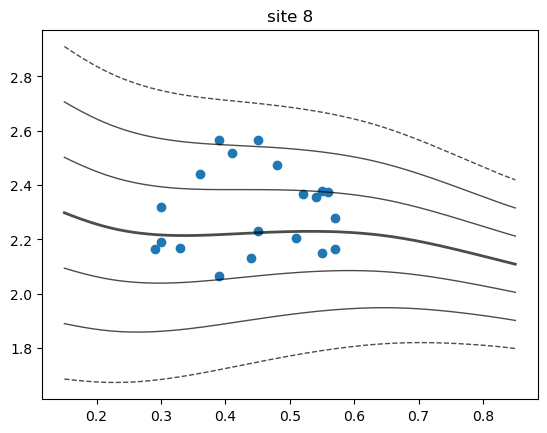

In [29]:
# Plot the original training set data points (site 0) into the centiles
plt.scatter(X_test[batch_effects_test[:,0]==8], Y_test[batch_effects_test[:,0]==8, 0])
# Note: for illustrative reasons, we plot both gender 0 and 1 onto the centiles for gender 0. In a real analysis, one would probably 
# make one plot per gender.
for i, v in enumerate(zscores):
    thickness = 1
    linestyle = "-"
    if v == 0:
        thickness = 2
    if abs(v) > 2:
        linestyle = "--"
    plt.plot(synthetic_X, q[i], linewidth = thickness, linestyle = linestyle, color = 'black', alpha = 0.7)

plt.title('site ' + str(be[0,0]))

## Case 2: Add data points from site 7 (Cambridge_Buckner) into the quantile plot of site 8 (Cleveland)

We have now plotted the cebtiles for site 8 and plotted the raw data from site 8 in it. How can we add data from another site?

1. Create a forward prediction for the covariate combination of each individual for site 7 for site 8.
2. Use yhat and s2 to invert z score for those individuals.

Rationale:

The zscores that the model produces are normalized for site. Hence, the z-socres are comparable in z-score space.
In order to convert the data points back into different site spaces, we need to revert the z-score transformation.

### Some (rather informal) math

$z_{7} = z_8$

$z_7 = \frac{\hat{y}_8 - y_*}{s_8}$

$z_7 * s_8 - \hat{y_8} = -y_*$

In [30]:
# Select individuals from site 7
X_test_7=X_test[batch_effects_test[:,0]==7]
n_synthetic_samples = sum(batch_effects_test[:,0]==7)

# Create a batch effect file for forward predictions in site 8. We hence select 8 as batch effect ID. 
# We choose gender 0 and site 8.
be = np.zeros((n_synthetic_samples,2))
eights = np.ones((n_synthetic_samples,1))*8
be[:,0] = eights[:,0]
be=be.astype(int)

# save individuals and create path
with open('X_test_7_in_8.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_test_7), file)
    
X_test_7_path = os.path.join(processing_dir, 'X_test_7_in_8.pkl')

#save batch effect and create path
with open('be_8.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(be), file)
    
be_8_path = os.path.join(processing_dir, 'be_8.pkl')

In [31]:
## Make a forward prediction for the individuals in site 7 for the batch effect of site 8.

ptk.normative.predict(covfile=X_test_7_path,
                      inputsuffix='_estimate',
                      respfile=None,
                      tsbefile=be_8_path,
                      model_path=output_path,
                      alg='hbr',
                      outputsuffix='_X_test_7_in_8')

Sampling: [y_like]


Loading data ...
Prediction by model  1 of 2


Prediction by model  2 of 2


Sampling: [y_like]


Writing outputs ...


(array([[2.2362347 , 2.2487398 ],
        [2.22404934, 2.21881415],
        [2.26037583, 2.274457  ],
        [2.25457129, 2.25149516],
        [2.23814587, 2.24560237],
        [2.22477141, 2.21991103],
        [2.24909082, 2.23648043],
        [2.25571411, 2.26790714],
        [2.21291896, 2.19551814],
        [2.22185851, 2.19913186],
        [2.2424913 , 2.23699884],
        [2.24879178, 2.26478888],
        [2.27817642, 2.28172971],
        [2.25818553, 2.27303814],
        [2.27557878, 2.28488598],
        [2.25868338, 2.27356108],
        [2.24034036, 2.26193443],
        [2.25997294, 2.24931257],
        [2.25165362, 2.25624297],
        [2.25669116, 2.25409853],
        [2.24127113, 2.24873711],
        [2.25635922, 2.25626822],
        [2.22587854, 2.23377519],
        [2.25401923, 2.24685217],
        [2.25266392, 2.25713428],
        [2.24358547, 2.23497205],
        [2.25158793, 2.25819093],
        [2.240206  , 2.24463621],
        [2.24738381, 2.23974096],
        [2.272

### Case 2: Load the yhat and s2 for subjects from site 7 for site 8

Now we load the data we have just created.

In [32]:
yhat_Xtest7in8 = ldpkl(os.path.join(processing_dir, "yhat_Xtest7in8.pkl"))
ys2_Xtest7in8 = ldpkl(os.path.join(processing_dir, "ys2_Xtest7in8.pkl"))

In [33]:
# We also load the original z-scores.
z_scores = ldpkl(os.path.join(processing_dir, "Z_estimate.pkl"))

In [34]:
# Look at the data. We only select the first IDP.

yhat_Xtest7in8[0]
ys2_Xtest7in8[0]

0      0.044817
1      0.042046
2      0.048859
3      0.047062
4      0.036930
         ...   
99     0.046246
100    0.045190
101    0.043965
102    0.048366
103    0.049226
Name: 0, Length: 104, dtype: float64

### Case 2: Back calculation

In [35]:
# Make the back transformation
y_adj = z_scores[batch_effects_test[:,0]==7][0].to_numpy() * ys2_Xtest7in8[0].to_numpy() - yhat_Xtest7in8[0].to_numpy()

In [36]:
y_adj = y_adj * (-1)

### Case 2: Plotting
We now create a plot that contains the transfromed data from site 7, the original data from site 8 and the centiles from site 8.

Text(0.5, 1.0, 'site [8 0]')

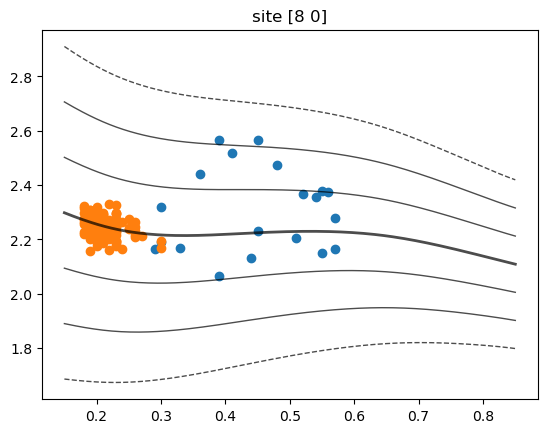

In [37]:
# Plot the transformed data from site 7,  the original data from site 8 and the centiles from site 8.

plt.scatter(X_test[batch_effects_test[:,0]==8], Y_test[batch_effects_test[:,0]==8, 0])
plt.scatter(X_test[batch_effects_test[:,0]==7], y_adj)
# plot centiles
for i, v in enumerate(zscores):
    thickness = 1
    linestyle = "-"
    if v == 0:
        thickness = 2
    if abs(v) > 2:
        linestyle = "--"
    plt.plot(synthetic_X, q[i], linewidth = thickness, linestyle = linestyle, color = 'black', alpha = 0.7)

plt.title('site ' + str(be[0]))

## Case 3: Transter model: Make predictions/adjustments for unseen sites.

The transfer requires an adaptation (training) and a test data set. We are going to use the held-out training data set for that.

The trainsfer model works in two stages: 
1. The adaptation data set is used to refit the model with priors derived from the previous model
2. Predictions and evalations are made for the hold-out test data.

In [38]:
# Create a new folder for the transfer models and create directory.
txfer_output_path = os.path.join(processing_dir,'Transfer')
os.makedirs(txfer_output_path, exist_ok=True)

### Case 3: Load the held out data

In [39]:
# Load the held out data.
X_adapt = (new_sites_tr['age']/100).to_numpy(dtype=float)
Y_adapt = new_sites_tr[idps].to_numpy(dtype=float)
batch_effects_adapt = new_sites_tr[['sitenum','sex']].to_numpy(dtype=int)

X_test_txfr = (new_sites_te['age']/100).to_numpy(dtype=float)
Y_test_txfr = new_sites_te[idps].to_numpy(dtype=float)
batch_effects_test_txfr = new_sites_te[['sitenum','sex']].to_numpy(dtype=int)

In [40]:
# Let's have a look at the holdout data.
print(batch_effects_test_txfr.shape)
print(batch_effects_adapt.shape)
print(X_adapt.shape)
print(Y_adapt.shape)

(139, 2)
(38, 2)
(38,)
(38, 2)


In [41]:
# save the dataframes

with open(os.path.join(processing_dir,'X_adaptation.pkl'), 'wb') as file:
    pickle.dump(pd.DataFrame(X_adapt), file)
with open(os.path.join(processing_dir,'Y_adaptation.pkl'), 'wb') as file:
    pickle.dump(pd.DataFrame(Y_adapt), file) 
with open(os.path.join(processing_dir,'adbefile.pkl'), 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_adapt), file) 

# save the dataframes
with open(os.path.join(processing_dir,'X_test_txfr.pkl'), 'wb') as file:
    pickle.dump(pd.DataFrame(X_test_txfr), file)
with open(os.path.join(processing_dir, 'Y_test_txfr.pkl'), 'wb') as file:
    pickle.dump(pd.DataFrame(Y_test_txfr), file) 
with open(os.path.join(processing_dir, 'txbefile.pkl'), 'wb') as file:
    pickle.dump(pd.DataFrame(batch_effects_test_txfr), file) 


In [42]:
# Let's have a look at the batch effect IDs.
batch_effects_adapt

array([[20,  1],
       [20,  0],
       [20,  1],
       [20,  1],
       [20,  0],
       [20,  0],
       [20,  1],
       [20,  1],
       [20,  0],
       [20,  0],
       [20,  1],
       [20,  0],
       [20,  1],
       [20,  0],
       [20,  1],
       [20,  1],
       [20,  0],
       [20,  0],
       [21,  1],
       [21,  1],
       [21,  0],
       [21,  1],
       [21,  0],
       [21,  1],
       [21,  0],
       [21,  1],
       [21,  1],
       [21,  0],
       [21,  1],
       [21,  1],
       [21,  0],
       [21,  1],
       [21,  1],
       [21,  1],
       [21,  1],
       [21,  1],
       [21,  0],
       [21,  0]])

### Case 3: Run the transfer model

We now run the transfer. We do that in a loop, running over all (two) idps we have selected.

In [43]:
# We have to do the transfer in a loop as we are going to loop over IDPs

for idx, measure in enumerate(idps):

    # save an individual Y_adaptation set file
    Y_adaptation_onefeature = Y_adapt[:,idx]
    with open(os.path.join(txfer_output_path,f'{idx+1}'+'_Y_adaptation_onefeature.pkl'), 'wb') as file:
        pickle.dump(pd.DataFrame(Y_adaptation_onefeature), file)
 
    Y_test_txfr_onefeature = Y_test_txfr[:,idx]
    with open(os.path.join(txfer_output_path,f'{idx+1}'+'_Y_test_txfr_onefeature.pkl'), 'wb') as file:
        pickle.dump(pd.DataFrame(Y_test_txfr_onefeature), file)
 
           
    respfile_path = os.path.join(txfer_output_path,f'{idx+1}'+'_Y_adaptation_onefeature.pkl')
    covfile_path = os.path.join(processing_dir, 'X_adaptation.pkl')
    adbefile = os.path.join(processing_dir, 'adbefile.pkl')
    
    testrespfile_path = os.path.join(txfer_output_path, f'{idx+1}'+'_Y_test_txfr_onefeature.pkl')
    testcovfile_path = os.path.join(processing_dir,'X_test_txfr.pkl')
    txbefile = os.path.join(processing_dir, 'txbefile.pkl')
   
    output_path = os.path.join(processing_dir, 'Models/') 
    log_dir = os.path.join(processing_dir, 'log/')
    

    transfer_suffix = '_transfer_'+f'{idx+1}'
    ptk.normative.transfer(covfile=covfile_path, 
                           respfile=respfile_path,
                           trbefile=adbefile,
                           model_type='bspline',
                           linear_sigma = 'True',
                           random_intercept_sigma = 'True',
                           random_slope_sigma = 'True',
                           linear_mu='True',
                           random_intercept_mu='True',
                           random_slope_mu='True',
                           alg='hbr', 
                           model_path = output_path,
                           log_path=log_dir, 
                           binary=True,
                           output_path=txfer_output_path, 
                           testcov=testcovfile_path,
                           tsbefile=txbefile,
                           #trbefile=trbefile,
                           testresp = testrespfile_path,
                           inputsuffix = "_estimate",
                           outputsuffix=transfer_suffix, 
                           savemodel=True)

Loading data ...
Using HBR transform...
Transferring model  1 of 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_slope_mu, sigma_slope_mu, offset_slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, mu_slope_sigma, sigma_slope_sigma, offset_slope_sigma, mu_intercept_sigma, sigma_intercept_sigma, offset_intercept_sigma]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [y_like]


Evaluating the model ...
Writing outputs ...
Loading data ...
Using HBR transform...
Transferring model  1 of 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_slope_mu, sigma_slope_mu, offset_slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, mu_slope_sigma, sigma_slope_sigma, offset_slope_sigma, mu_intercept_sigma, sigma_intercept_sigma, offset_intercept_sigma]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [y_like]


Evaluating the model ...
Writing outputs ...


In [44]:
# Load the transfer mean and variance.

yhat_transfer = ldpkl(os.path.join(processing_dir, "yhat_transfer1.pkl"))
ys2_transfer = ldpkl(os.path.join(processing_dir, "ys2_transfer1.pkl"))

Again, we create dummy data to use the get_mcmc_quantiles function.

In [45]:
# create dummy zscores
zscores = np.arange(-3,4)[:,np.newaxis]

# We need to provide a matrix of shape [N,d]. In this case d=1, so we need to expand this matrix with a single 'empty' dimension.
# We can do this by using the np.newaxis in this way.
# Create sythetic X achsis
n_synthetic_samples = 200
synthetic_X = np.linspace(0.15, 0.85, n_synthetic_samples)[:,np.newaxis]
# choose type of site effect by cerating intercept offset (or not).  We choose gender 0 and site 21.
be = np.zeros((n_synthetic_samples,2))
twenties = np.ones((n_synthetic_samples,1))*21
be[:,0] = twenties[:,0]
be=be.astype(int)

In [46]:
# Load the transfer model. Make sure to choose the transfer path.
nm_transfer1 = ldpkl(os.path.join(txfer_output_path, 'NM_0_0_transfer1.pkl'))

In [47]:
# We generate an object to hold the quantiles
q = nm_transfer1.get_mcmc_quantiles(synthetic_X, be,  zscores)

Sampling: [y_like]


Text(0.5, 1.0, 'site 21')

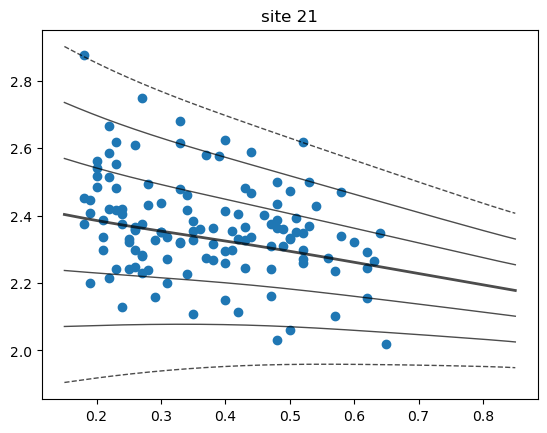

In [48]:
# Plot the data onto the centiles obtained from the transfer model
plt.scatter(X_test_txfr[batch_effects_test_txfr[:,0]==21], Y_test_txfr[(batch_effects_test_txfr[:,0]==21),0])
# Note: we are again plotting both genders. In a real analysis example, one might want to create two plots, one for each gender.
for i, v in enumerate(zscores):
    thickness = 1
    linestyle = "-"
    if v == 0:
        thickness = 2
    if abs(v) > 2:
        linestyle = "--"
    plt.plot(synthetic_X, q[i], linewidth = thickness, linestyle = linestyle, color = 'black', alpha = 0.7)

plt.title('site ' + str(be[0,0]))